**Trabalho Prático da disciplina Processamento Digital de Imagens (PDI)**

**Projeto ImpactLab**

Prof. Felipe Oliveira

**Data de entrega: 16/12/2024**


---



---



**Problema:**

Imagens capturadas em ambientes não controlados estão facilmente sujeitas a problemas de luminosidade, resultando em imagens com aspecto escuro e com limitada definição de detalhes da cena. Esse tipo de problema, além de prejudicar a qualidade das imagens capturadas por operadores não profissionais, também prejudica tarefas de análise de imagens.


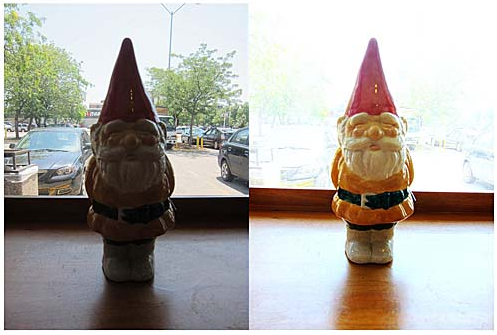



---



**Descrição:**

Implemente uma solução utilizando a linguagem Python e as técnicas fornecidas na disciplina PDI para compensar a baixa luminosidade de imagens. A solução proposta deve combinar as operações apresentadas abaixo de forma a maximizar a qualidade das imagens.
Encontre a ordem das operações mais efetiva para solucionar o problema e o melhor conjunto de parâmetros para as diferentes funções.

Obs.:

* Não é obrigado utilizar todas as funções;
* Funções não apresentadas nesse material podem ser utilizadas.


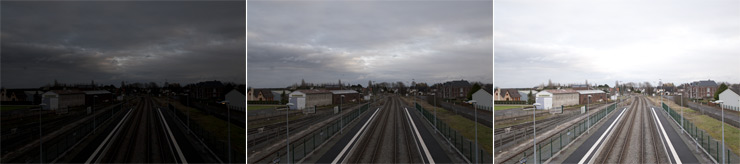

---


**O que entregar:**

Google Colab com a descrição completa da solução proposta, destacando a **sequência das operações**, os **parâmetros definidos**, a **justificativa para os parâmetros** (evidenciando que houve uma pesquisa e exploração dos parâmetros) e detalhamento completo do funcionamento de cada operação.

Adicionalmente, devem ser apresentados os resultados quantitativos por meio das métricas PSNR, SSIM, BRISQUE e NIQE.

Obs.: Para obter os resultados finais deve ser calculada cada métrica, para cada imagem e posteriormente deve ser calculada a média dos resultados de cada métrica. Por exemplo: Para a métrica PSNR, calcule o valor do PSNR de cada imagem restaurada e por fim calcule a média dos PSNRs de todas as imagens.



---

**Base de Imagens (Dataset LOL)**

A base de imagens LOL (LOw-Light dataset) é composta por 485 pares de imagens de baixa luminosidade e luz normal. As imagens de baixa luminosidade contêm ruído produzido durante o processo de captura de fotos. A maioria das imagens são cenas internas. Todas as imagens têm resolução de 400x600.

O dataset pode ser baixado no link:

https://drive.google.com/file/d/1psMH1-zmI4rVJVELxr0ErkhduqpzJXwb/view?usp=sharing


Chen Wei, Wenjing Wang, Wenhan Yang, Jiaying Liu. Deep Retinex Decomposition for Low-Light Enhancement. British Machine Vision Conference (BMVC). 2018.

https://daooshee.github.io/BMVC2018website/



---



# **TÉCNICAS DE MELHORIA DE IMAGENS**

**Realce por Equalização de Histograma:**

* Equalização de Histograma Global;
* Equalização de Histograma Adaptativa (CLAHE).




In [ ]:
def global_histogram_equalization(image):
    """
    Aplica Equalização de Histograma Global em uma imagem.

    Args:
        image: numpy array representando a imagem de entrada em escala de cinza.

    Returns:
        numpy array da imagem com histograma equalizado.
    """
    return cv2.equalizeHist(image)

In [ ]:
def adaptive_histogram_equalization(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Aplica Equalização de Histograma Adaptativa (CLAHE) em uma imagem.

    Args:
        image: numpy array representando a imagem de entrada em escala de cinza.
        clip_limit: Limite de contraste para evitar over-enhancement.
        tile_grid_size: Tamanho do grid para dividir a imagem.

    Returns:
        numpy array da imagem equalizada adaptativamente.
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

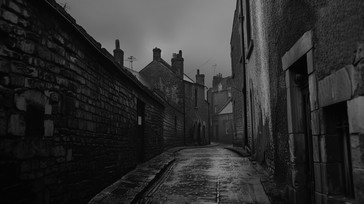

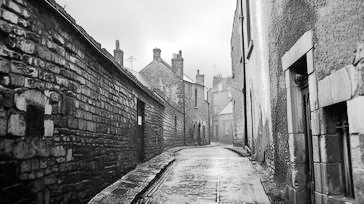

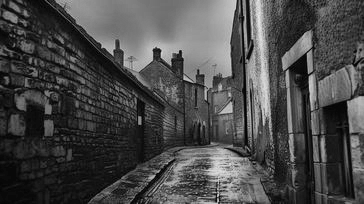

In [ ]:
if __name__ == "__main__":

    # Aplicar Equalização de Histograma Global
    #global_eq_image = global_histogram_equalization(gray_image)

    # Aplicar Equalização de Histograma Adaptativa (CLAHE)
    adaptive_eq_image = adaptive_histogram_equalization(gray_image, 2)

    cv2_imshow(gray_image)
    cv2_imshow(global_eq_image)
    cv2_imshow(adaptive_eq_image)

**Transformação Logarítmica:**

* Realce de detalhes em áreas escuras comprimindo a faixa de valores de intensidade.

In [ ]:
def logarithmic_transformation(image, c=1.0):
    """
    Aplica transformação logarítmica em uma imagem para realce de detalhes em áreas escuras.

    Args:
        image: numpy array representando a imagem de entrada em escala de cinza.
        c: Constante multiplicativa para ajustar a intensidade.

    Returns:
        numpy array da imagem transformada logaritmicamente.
    """
    # Converter a imagem para float para evitar truncamento durante a transformação
    image_float = image.astype(np.float32)

    # Aplicar a transformação logarítmica
    log_image = c * np.log1p(image_float)  # log1p calcula log(1 + x) para estabilidade numérica

    # Normalizar para o intervalo [0, 255]
    log_image = cv2.normalize(log_image, None, 0, 255, cv2.NORM_MINMAX)

    # Converter de volta para uint8
    return log_image.astype(np.uint8)

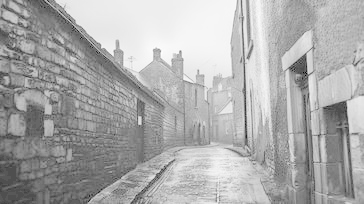

In [ ]:
if __name__ == "__main__":

    # Aplicar Transformação Logarítmica
    log_transformed_image = logarithmic_transformation(gray_image, c=5.0)

    cv2_imshow(log_transformed_image)


**Correção de Gamma:**

* Ajusta os níveis de brilho de acordo com um valor 𝛾. Útil para corrigir diferenças na resposta de sensores ou monitores.

In [ ]:
def gamma_correction(image, gamma=1.0):
    """
    Aplica correção de gamma em uma imagem para ajustar os níveis de brilho.

    Args:
        image: numpy array representando a imagem de entrada em escala de cinza ou RGB.
        gamma: Valor do gamma para ajuste. Valores gamma < 1 aumentam o brilho,
               valores gamma > 1 reduzem o brilho.

    Returns:
        numpy array da imagem corrigida com gamma.
    """
    # Normalizar a imagem para o intervalo [0, 1]
    image_normalized = image / 255.0

    # Aplicar a transformação gamma
    corrected_image = np.power(image_normalized, gamma)

    # Escalar de volta para [0, 255]
    corrected_image = (corrected_image * 255).astype(np.uint8)

    return corrected_image

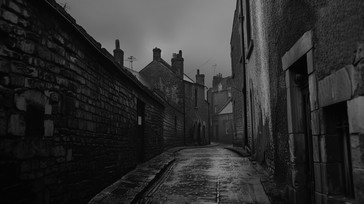

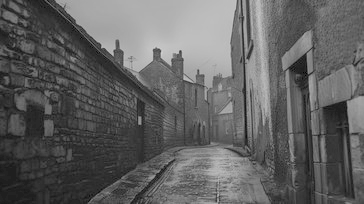

In [ ]:
if __name__ == "__main__":

    # Aplicar correção de gamma com um valor específico
    gamma_value = 0.5  # Exemplo: Reduzir brilho
    gamma_corrected_image = gamma_correction(gray_image, gamma=gamma_value)

    # Mostrar resultados
    cv2_imshow(gray_image)
    cv2_imshow(gamma_corrected_image)



**Técnicas de Filtragem:**

* Filtro Bilateral;
* Filtro Bilateral Adaptativo.



In [ ]:
def bilateral_filter(image, diameter=15, sigma_color=75, sigma_space=75):
    """
    Aplica filtro bilateral em uma imagem para suavizar enquanto preserva bordas.

    Args:
        image: numpy array representando a imagem de entrada (escala de cinza ou RGB).
        diameter: Diâmetro dos pixels vizinhos considerados para filtragem.
        sigma_color: Desvio padrão no espaço de cores.
        sigma_space: Desvio padrão no espaço de coordenadas.

    Returns:
        numpy array da imagem filtrada bilateralmente.
    """
    return cv2.bilateralFilter(image, d=diameter, sigmaColor=sigma_color, sigmaSpace=sigma_space)

In [ ]:
def adaptive_filter(image, kernel_size=5, sigma_color=75, sigma_space=75):
    """
    Aplica um filtro bilateral adaptativo manualmente, calculando o filtro bilateral
    em blocos da imagem para ajustar características locais.

    Args:
        image: numpy array representando a imagem de entrada (escala de cinza).
        kernel_size: Tamanho do kernel usado para dividir a imagem em blocos.
        sigma_color: Desvio padrão no espaço de cores.
        sigma_space: Desvio padrão no espaço de coordenadas.

    Returns:
        numpy array da imagem filtrada adaptativamente.
    """
    # Certifique-se de que a imagem está em escala de cinza
    if len(image.shape) == 3:
        raise ValueError("A imagem para o filtro adaptativo deve estar em escala de cinza.")

    # Obter dimensões da imagem
    h, w = image.shape

    # Inicializar a imagem de saída
    output = np.zeros_like(image, dtype=np.float32)

    # Aplicar filtro bilateral por blocos
    for i in range(0, h, kernel_size):
        for j in range(0, w, kernel_size):
            # Determinar os limites do bloco
            i_end = min(i + kernel_size, h)
            j_end = min(j + kernel_size, w)

            # Extrair bloco
            block = image[i:i_end, j:j_end]

            # Aplicar filtro bilateral no bloco
            filtered_block = cv2.bilateralFilter(block, d=-1, sigmaColor=sigma_color, sigmaSpace=sigma_space)

            # Colocar o bloco filtrado na imagem de saída
            output[i:i_end, j:j_end] = filtered_block

    return np.clip(output, 0, 255).astype(np.uint8)

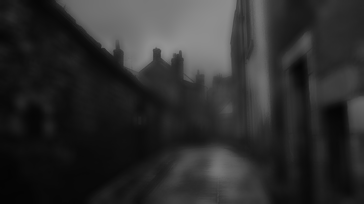

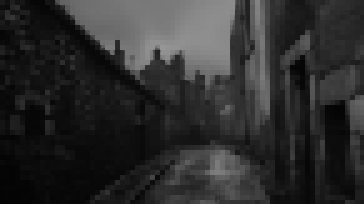

In [ ]:
if __name__ == "__main__":

    # Aplicar filtro bilateral
    bilateral_filtered_image = bilateral_filter(gray_image)

    # Aplicar filtro adaptativo
    adaptive_filtered_image = adaptive_filter(gray_image)

    # Mostrar resultados
    cv2_imshow(bilateral_filtered_image)
    cv2_imshow(adaptive_filtered_image)

**Métodos Baseados em Decomposição de Retinex:**

* Single Scale Retinex (SSR): Usa uma escala fixa de suavização para calcular a iluminação.
* Multi-Scale Retinex (MSR): Combina múltiplas escalas de suavização para uma compensação mais robusta.

In [ ]:
def single_scale_retinex(image, sigma=30):
    """
    Aplica o método Single Scale Retinex (SSR) para compensação de luminosidade.

    Args:
        image: numpy array representando a imagem em escala de cinza.
        sigma: Desvio padrão do filtro Gaussiano.

    Returns:
        numpy array da imagem processada pelo SSR.
    """
    # Convertendo para float para evitar problemas de precisão
    image = image.astype(np.float32) + 1.0

    # Aplicando filtro Gaussiano
    gaussian = cv2.GaussianBlur(image, (0, 0), sigma)

    # Calculando o SSR
    retinex = np.log10(image) - np.log10(gaussian + 1e-6)

    return cv2.normalize(retinex, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


In [ ]:
def multi_scale_retinex(image, scales=[15, 80, 250]):
    """
    Aplica o método Multi-Scale Retinex (MSR) para compensação de luminosidade.

    Args:
        image: numpy array representando a imagem em escala de cinza.
        scales: Lista de desvios padrão para os diferentes filtros Gaussianos.

    Returns:
        numpy array da imagem processada pelo MSR.
    """
    # Convertendo para float para evitar problemas de precisão
    image = image.astype(np.float32) + 1.0

    # Calculando MSR combinando diferentes escalas
    retinex = np.zeros_like(image, dtype=np.float32)
    for sigma in scales:
        gaussian = cv2.GaussianBlur(image, (0, 0), sigma)
        retinex += np.log10(image) - np.log10(gaussian + 1e-6)

    retinex = retinex / len(scales)  # Média das escalas

    return cv2.normalize(retinex, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


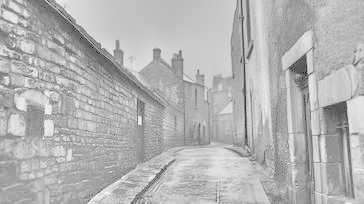

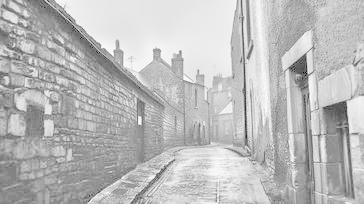

In [ ]:
if __name__ == "__main__":

    # Aplicar Single Scale Retinex (SSR)
    ssr_result = single_scale_retinex(gray_image)

    # Aplicar Multi-Scale Retinex (MSR)
    msr_result = multi_scale_retinex(gray_image)

    # Mostrar resultados
    cv2_imshow(ssr_result)
    cv2_imshow(msr_result)

**Realce de cores:**

Funções para ajuste das cores nas diferentes bandas da imagem colorida RGB.

* Enhance colors.
* Color correction.



In [ ]:
def enhance_colors(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Realça as cores de uma imagem para melhorar a qualidade visual após compensação de luminosidade.

    Args:
        image: numpy array representando a imagem de entrada (em RGB).
        clip_limit: Limite de contraste para CLAHE (Equalização Adaptativa).
        tile_grid_size: Tamanho da grade para dividir a imagem no CLAHE.

    Returns:
        numpy array da imagem com cores realçadas.
    """
    # Converter imagem de RGB para o espaço LAB
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Separar os canais L, A, B
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Aplicar CLAHE no canal L (luminosidade)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_l_channel = clahe.apply(l_channel)

    # Combinar os canais novamente
    enhanced_lab_image = cv2.merge((enhanced_l_channel, a_channel, b_channel))

    # Converter de volta para RGB
    enhanced_image = cv2.cvtColor(enhanced_lab_image, cv2.COLOR_LAB2RGB)

    return enhanced_image

In [ ]:
def color_correction(image, intensity=1.0):
    """
    Aplica correção de cores a uma imagem, ajustando o contraste com base no histograma.

    Args:
        image: numpy array representando a imagem de entrada (em RGB ou escala de cinza).
        intensity: Float que controla o nível de intensidade do ajuste (valor padrão é 1.0).

    Returns:
        numpy array representando a imagem com a correção de cor aplicada.
    """
    # Dividir a imagem nos canais de cor (R, G, B ou equivalente em escala de cinza)
    channels = cv2.split(image)
    results = []

    # Determinar a saturação com base na intensidade
    saturation = channels[0].shape[0] * channels[0].shape[1] * intensity / 500.0

    for channel in channels:
        # Calcular o histograma do canal
        histogram = cv2.calcHist([channel], [0], None, [256], [0, 256], accumulate=False)

        # Determinar os valores lowvalue e highvalue para a correção de contraste
        low_value = np.searchsorted(np.cumsum(histogram), saturation)
        high_value = 255 - np.searchsorted(np.cumsum(histogram[::-1]), saturation)

        # Criar a LUT (Look-Up Table) para o ajuste linear
        lut = np.array([
            0 if i < low_value else
            (255 if i > high_value else
             round((i - low_value) / (high_value - low_value) * 255))
            for i in np.arange(0, 256)
        ], dtype="uint8")

        # Aplicar a LUT ao canal
        corrected_channel = cv2.LUT(channel, lut)
        results.append(corrected_channel)

    # Combinar os canais corrigidos novamente
    corrected_image = cv2.merge(results)

    return corrected_image

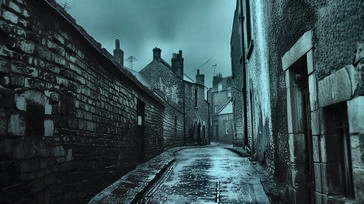

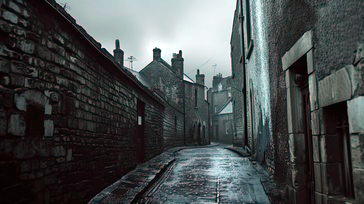

In [ ]:
if __name__ == "__main__":

    image2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Realçar as cores da imagem
    enhanced_image = enhance_colors(image2)

    # Corrigir as cores da imagem
    corrected_image = color_correction(image2, intensity=1.0)

    # Mostrar resultados
    cv2_imshow(enhanced_image)
    cv2_imshow(corrected_image)

**Máscara de nitidez (sharpening)**

* Realce de imagens desfocadas, aprimorando a definição de bordas em imagens.

In [ ]:
def sharpen_with_mask(image, kernel=(5, 5), sigma=0.5, intensity=1.0, threshold=0):
    """
    Aplica uma máscara de nitidez à imagem para melhorar detalhes e bordas.

    Args:
        image: numpy array representando a imagem de entrada (em escala de cinza ou RGB).
        kernel: Tuple definindo o tamanho do kernel da suavização Gaussiana.
        sigma: Float indicando o desvio padrão usado na suavização Gaussiana.
        intensity: Float que controla o nível de nitidez aplicado à imagem.
        threshold: Valor limite para preservar regiões de baixo contraste.

    Returns:
        numpy array representando a imagem com a máscara de nitidez aplicada.
    """
    # Aplicar suavização Gaussiana
    smoothed = cv2.GaussianBlur(image, kernel, sigma)

    # Calcular a máscara de nitidez
    sharpness = float(intensity + 1) * image - float(intensity) * smoothed

    # Garantir que os valores estejam no intervalo válido [0, 255]
    sharpness = np.maximum(sharpness, np.zeros(sharpness.shape))
    sharpness = np.minimum(sharpness, 255 * np.ones(sharpness.shape))
    sharpness = sharpness.round().astype(np.uint8)

    # Aplicar limiar opcional para preservar áreas de baixo contraste
    if threshold > 0:
        low_contrast_mask = np.absolute(image - smoothed) < threshold
        np.copyto(sharpness, image, where=low_contrast_mask)

    return sharpness

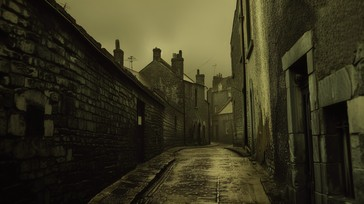

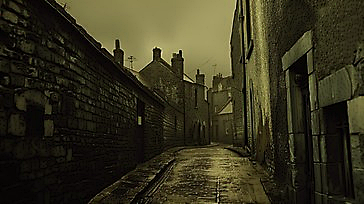

In [ ]:
if __name__ == "__main__":

    # Aplicar máscara de nitidez
    sharpened_image = sharpen_with_mask(image, kernel=(5, 5), sigma=1.0, intensity=2.0, threshold=10)

    # Mostrar resultados
    cv2_imshow(image)
    cv2_imshow(sharpened_image)


**MÉTRICAS DE AVALIAÇÃO DE QUALIDADE**

As métricas de avaliação de qualidade em imagens são utilizadas para mensurar a qualidade das imagens geradas, em relação às imagens de referência.

Existem métricas de qualidade, **com referência** (quando existem imagens de referência - em "boa qualidade") e **sem referência** (quando não existem imagens de referência - em "boa qualidade").

As métricas de qualidade com referência que iremos utilizar são:

*   PSNR (Peak Signal-to-Noise Ratio).
*   SSIM (Structural Similarity Index).

Para as métricas PSNR E SSIM **valores mais altos** são melhores.


As métricas de qualidade sem referência que iremos utilizar são:

*   BRISQUE (Blind/Referenceless Image Spatial Quality Evaluator).
*   NIQE (Natural Image Quality Evaluator).

Para as métricas BRISQUE E NIQE **valores mais baixos** são melhores.

In [ ]:
def calculate_psnr(imageA, imageB):
    # Ensure the images have the same size
    if imageA.shape != imageB.shape:
        raise ValueError("The images must have the same dimensions.")

    # Calculate the PSNR
    psnr_value = cv2.PSNR(imageA, imageB)

    return psnr_value


In [ ]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(image1, image2, win_size=3):

    if image1 is None or image2 is None:
        raise ValueError("Uma ou ambas as imagens não puderam ser carregadas.")

    # Converter as imagens de BGR para RGB
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

    # Certificar-se de que as imagens têm as mesmas dimensões
    if image1.shape != image2.shape:
        raise ValueError("As imagens devem ter as mesmas dimensões.")

    # Calcular o SSIM para cada canal e tirar a média
    ssim_value = ssim(image1, image2, multichannel=True, win_size=win_size)

    return ssim_value


In [ ]:
def calculate_mscn_coefficients(image):
    c = np.fft.fft2(image)
    c_shifted = np.fft.fftshift(c)
    magnitude = np.abs(c_shifted)
    log_magnitude = np.log(1.0 + magnitude)
    c_shifted_real = np.real(c_shifted)
    c_shifted_imag = np.imag(c_shifted)
    return c_shifted_real, c_shifted_imag, magnitude, log_magnitude


def calculate_mscn_features(image):
    c_shifted_real, c_shifted_imag, _, log_magnitude = calculate_mscn_coefficients(image)
    std_dev = np.std(log_magnitude)
    mean = np.mean(log_magnitude)
    return [std_dev, mean]


def brisque_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ms_std_dev, ms_mean = calculate_mscn_features(gray)
    return [ms_std_dev, ms_mean]


def getBRISQUE(image):
    features = brisque_features(image)
    weights = [-0.0977446, 0.0270277, 0.00090095, 0.0793246, 0.0476165, -0.033992, -0.0535509, 0.276186, 0.189205, 0.255546,
               0.120626, 0.0471861, -0.18469, 0.154051, -0.173411, -0.413456]
    intercept = 18.9217
    score = intercept
    for i in range(len(features)):
        score += features[i] * weights[i]
    return score


In [ ]:
from numpy import mean
from numpy import std
from skimage import color, io

def getNIQE(img):	# Carregue a imagem usando scikit-image (substitua 'imagem.jpg' pelo caminho da sua imagem)
    # Converta a imagem para escala de cinza
    imagem_gray = color.rgb2gray(img)

    # Calcule a média e o desvio padrão do contraste local
    mean_local_contrast = np.mean(np.abs(np.gradient(imagem_gray)))
    std_local_contrast = np.std(np.abs(np.gradient(imagem_gray)))

    # Calcule o NIQE
    niqe_score = 1.0 / (1 + 6.6 * mean_local_contrast + 0.228 * std_local_contrast)

    return niqe_score


In [ ]:
if __name__ == "__main__":

  print("Métricas de Qualidade Cem Referência")
  print("PSNR: ", calculate_psnr(sharpened_image, image))
  print("SSIM: ", calculate_ssim(sharpened_image, image))

  print("Métricas de Qualidade Sem Referência")
  print("BRISQUE: ", getBRISQUE(sharpened_image))
  print("NIQE: ", getNIQE(sharpened_image))


Métricas de Qualidade Cem Referência
PSNR:  27.911808972226662
SSIM:  0.9117204862221128
Métricas de Qualidade Sem Referência
BRISQUE:  19.056431041322153
NIQE:  0.8304481675062035
